# Exploring uncertainty propagation with Python

This notebook looks at some aspects of uncertainty propagation using Python and related libraries.

I recommend the [Whirlwind Tour of Python](https://jakevdp.github.io/WhirlwindTourOfPython/) and the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) both by Jake VanderPlas.

Below, I look at some basic tasks done with **NumPy**, **Matplotlib** and **Uncertainties** packages.

In [1]:
# Usually import packages via a handle to the functions in them using import ... as ...
#
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import uncertainties as unc
%matplotlib inline

In [2]:
# Useful plot default
mpl.rcParams['figure.figsize'] = 12.0,6.0  # Roughly 12 cm wde by 8 cm high
mpl.rcParams['font.size'] = 14.0 # Use 14 point font

## Generate distributions

Use the Numpy functions to generate test distributions

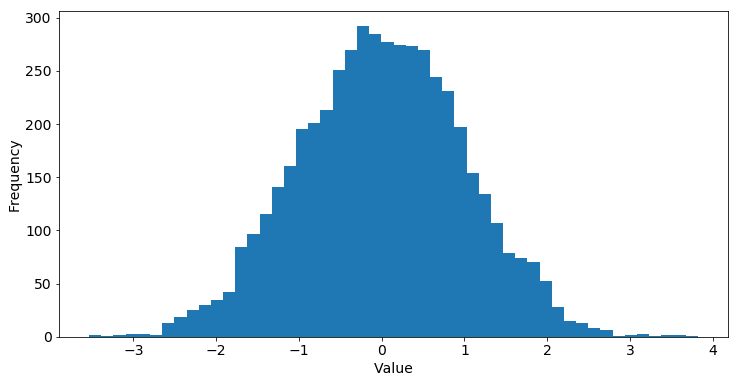

In [3]:
# Generate a random distribution: Gaussian with mean = 0 and Std Dev = 1

gaussian_data = np.random.randn(5000)
# exponential_data = np.random.exponential(scale=1.0,size=5000)
# uniform_data = np.random.uniform(low=-0.5, high=0.5, size=5000)

# Plot a histogram
plt.hist(gaussian_data,bins=50)
plt.xlabel('Value')
plt.ylabel('Frequency');

Calculate the mean & standard deviation

In [4]:
print('Mean = {:.4f}'.format(gaussian_data.mean()))
print('Standard deviation = {:.4f}'.format(np.std(gaussian_data)))

Mean = -0.0001
Standard deviation = 1.0012


Use this to create two "experimental" distributions and one "result" equal to their sum.  Plot them

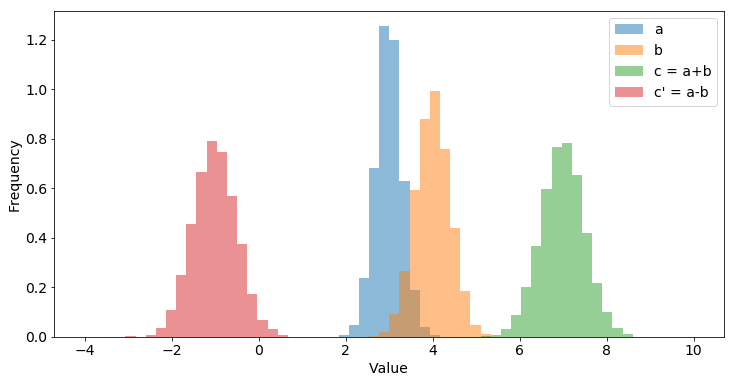

In [5]:
a = 3.0 + 0.3*np.random.randn(5000)
b = 4.0 + 0.4*np.random.randn(5000)

c = a+b
c_prime = a-b

kwargs = dict(density=True, bins=60, alpha=.5, range=(-4,10))

plt.hist(a, **kwargs, label='a')
plt.hist(b, **kwargs, label='b')
plt.hist(c, **kwargs, label='c = a+b')
plt.hist(c_prime, **kwargs, label="c' = a-b")
plt.xlabel('Value')
plt.ylabel('Frequency');
plt.legend();

### Calculate the expected standard deviation using the sum/difference rule

Then compare it to what you get from the sum of the two distributions.

Sum/difference rule: If $c = a \pm b$ then

$$\sigma_c = \sqrt{\sigma_a^2 + \sigma_b^2}$$


In [6]:
sigma_c = np.sqrt(a.std()**2 + b.std()**2)
print('Expected std. dev. = {:.4f}'.format(sigma_c))

Expected std. dev. = 0.4985


In [7]:
print('Actual std. dev. for a+b = {:.4f}'.format(c.std()))
print('Actual std. dev. for a-b = {:.4f}'.format(c_prime.std()))

Actual std. dev. for a+b = 0.5008
Actual std. dev. for a-b = 0.4961


## Try multiplication and division

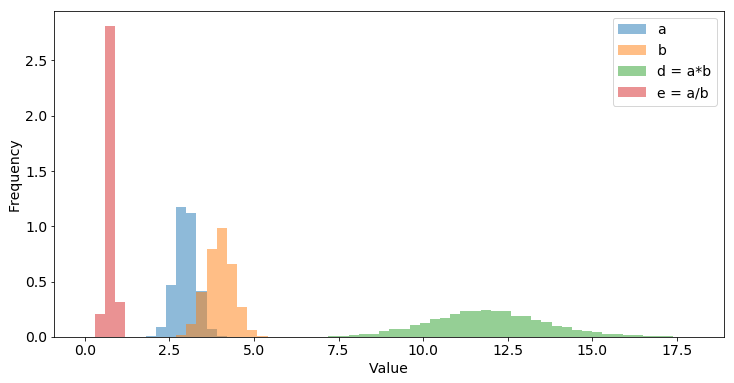

In [8]:
d = a*b
e = a/b

kwargs = dict(density=True, bins=60, alpha=.5, range=(0,18))

plt.hist(a,**kwargs, label='a')
plt.hist(b,**kwargs, label='b')
plt.hist(d,**kwargs, label='d = a*b')
plt.hist(e,**kwargs, label='e = a/b')
plt.xlabel('Value')
plt.ylabel('Frequency');
plt.legend();

### Calculate the expected standard deviation using the product/quotient rule

Then compare it to what you get from the sum of the two distributions.

product/quotient rule: If $c = ab$ or $c = a/b$ then

$$\sigma_c = |c|\sqrt{(\sigma_a/a)^2 + (\sigma_b/b)^2}$$

In [9]:
eps = np.sqrt((a.std()/a.mean())**2 + (b.std()/b.mean())**2)
sigma_d = np.abs(d.mean())*eps
sigma_e = np.abs(e.mean())*eps

print('Fractional std. dev = {:.4f}'.format(eps))
print('Expected std. dev. for product ({:.2f}) = {:.4f}'.format(d.mean(), sigma_d))
print('Expected std. dev. for quotient ({:.2f})= {:.4f}'.format(e.mean(), sigma_e))

Fractional std. dev = 0.1416
Expected std. dev. for product (11.95) = 1.6912
Expected std. dev. for quotient (0.75)= 0.1068


In [10]:
print('Actual std. dev. for a*b = {:.4f}'.format(d.std()))
print('Actual std. dev. for a/b = {:.4f}'.format(e.std()))

Actual std. dev. for a*b = 1.7018
Actual std. dev. for a/b = 0.1084


### What about powers?

Squaring data is different than multiplying data because of **correlations**.  When a result is raised to a power, the fractional uncertainty is multiplied by that power.  The rule is

If $c = a^m$ then $\varepsilon_c = m\varepsilon_a$, i.e.,

$$\sigma_c = m|c|\varepsilon_a$$

Let's try it and compare to multiplying with and without correlations.

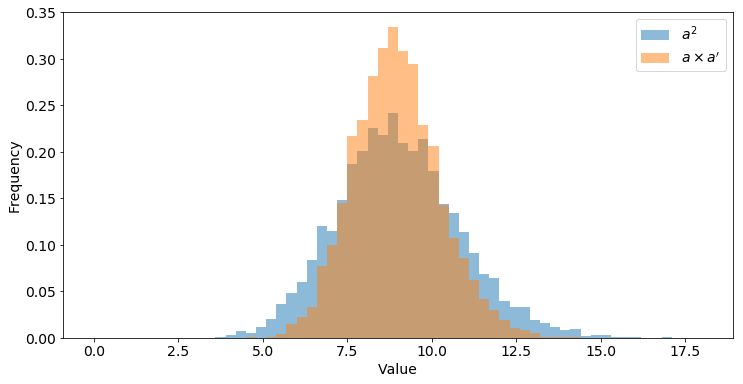

In [11]:
# Generate another independent distribution

a_prime = 3.0 + 0.3*np.random.randn(5000)  # same mean and std. dev as a

a_square = a**2 # square every element of a
a_x_a_prime = a * a_prime # multiply every element of a with every element of a_prime

kwargs = dict(density=True, bins=60, alpha=.5, range=(0,18))

plt.hist(a_square,**kwargs, label=r'$a^2$')
plt.hist(a_x_a_prime,**kwargs, label=r'$a\times a^\prime$')
plt.xlabel('Value')
plt.ylabel('Frequency');
plt.legend();

Compare to expectations. These are easiest to understand in terms of percent or fractional uncertainty.  For the uncorrelated data, expect the fractional uncertainty to be $\sqrt{2}\times 0.1$.  For the correlated data, expect it to be $2\times 0.1$.

In [12]:
print("Fractional std. dev. for a * a' = {:.3f}".format(a_x_a_prime.std()/a_x_a_prime.mean()))
print('Fractional std. dev. for a**2 = {:.3f}'.format(a_square.std()/a_square.mean()))

Fractional std. dev. for a * a' = 0.142
Fractional std. dev. for a**2 = 0.200


### The Uncertainties Package

Uncertainties will do almost all uncertainty propagation automatically.  You just need to create "uncertainty objects" which are Python custom types that have two parts: the "mean" and the "uncertainty".

Then for standard mathematical operations, one only needs to use these new objects in the calculation, and the uncertainty propagation occurs all by itself.

Here is an example:

In [13]:
# Create uncertainty objects
# a "ufloat" has a value and an uncertainty

ua = unc.ufloat(a.mean(),a.std())
ub = unc.ufloat(b.mean(),b.std())
uc = unc.ufloat(c.mean(),c.std())

print("ua =",ua,"\nub =",ub,"\nuc =", uc)
print("ua + ub =", ua + ub)

ua = 2.99+/-0.30 
ub = 4.0+/-0.4 
uc = 7.0+/-0.5
ua + ub = 7.0+/-0.5


Notice how the uncertainty was propagated to the sum of `a` and `b` automatically.

The package also has useful formatting code.  It prints the value and uncertainty to the same precision (same number of digits past the decimal point). 

In [14]:
print('c = {:.2u}'.format(uc))

# The "P" tag looks prettier.  "P" stands for "pretty print."

print('c = {:.2uP}'.format(uc*1e10))

c = 6.99+/-0.50
c = (6.99±0.50)×10¹⁰


To get each piece back out, use the attributes `n` or `nominal_value` and `s` or `std_dev`:

In [15]:
print('c nominal value = {:.3f}'.format(uc.nominal_value))
print('c standard deviation = {:.3f}'.format(uc.s))
print('c fractional standard_deviation = {:.3f}'.format(abs(uc.s/uc.n)))

c nominal value = 6.986
c standard deviation = 0.501
c fractional standard_deviation = 0.072


We will use **Uncertainties** for propagating uncertainty from now on.

## Pathological cases: When uncertainty propagation goes **wrong**.

Uncertainty propagation can break when the uncertainty is of the same magnitude as the value.

In [16]:
f = -4.0 + 0.5*np.random.randn(5000)
#g = 4.0 + 4*np.random.randn(5000)

f_sq = f*f

uf = unc.ufloat(f.mean(),f.std())
uf_sq = uf**2

print('f = {:.uP}'.format(uf))
print('f_sq = {:.2uP}'.format(unc.ufloat(f_sq.mean(),f_sq.std())))
print('From error propagation: uf_sq = {:.2uP}'.format(uf_sq))

f = -4.0±0.5
f_sq = 16.3±4.0
From error propagation: uf_sq = 16.0±4.0


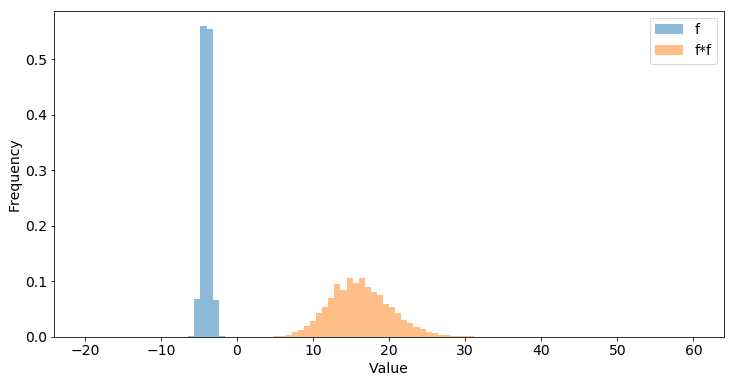

In [17]:
kwargs = dict(density=True, bins=100, alpha=.5, range=(-20,60))

plt.hist(f,**kwargs, label='f')
plt.hist(f_sq,**kwargs, label='f*f')
plt.xlabel('Value')
plt.ylabel('Frequency');
plt.legend();

### Now break things

Let the standard deviation cross 0.  Things get weird.

g = -4±4
g_sq = 32±39
From error propagation: ug_sq = 16±32


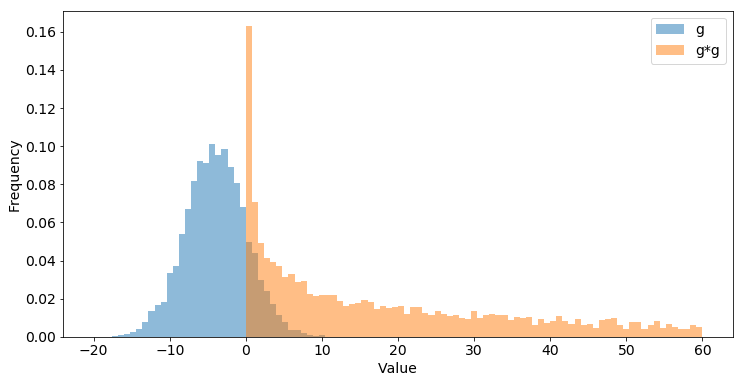

In [18]:
#f = -4.0 + 0.5*np.random.randn(5000)
g = -4.0 + 4.0*np.random.randn(5000)

g_sq = g*g

ug = unc.ufloat(g.mean(),g.std())
ug_sq = ug**2

print('g = {:.uP}'.format(ug))
print('g_sq = {:.2uP}'.format(unc.ufloat(g_sq.mean(),g_sq.std())))
print('From error propagation: ug_sq = {:.2uP}'.format(ug_sq))

kwargs = dict(density=True, bins=100, alpha=.5, range=(-20,60))

plt.hist(g,**kwargs, label='g')
plt.hist(g_sq,**kwargs, label='g*g')
plt.xlabel('Value')
plt.ylabel('Frequency');
plt.legend();

## What happens to uncertainty when you take an average?

It is common to average a set of measurements to get a better value.  Why should this be true?

Assume we have a distribution of measurements, like $a$.  Then we take averages of successive ones to get a *distribution of averages*.

Here is some code to do that:

In [19]:
# Select a range with a "slice"

N = 5
print('The first',N,'values:',np.round(a[0:N],3))
print('Their average:',np.round(np.mean(a[0:N]),3))

The first 5 values: [2.852 3.448 3.389 3.508 3.497]
Their average: 3.339


Allow the beginning and end to change with a variable:

In [20]:

N = 5
print('Means of succesive',N,'values:')

for i in range(10):
    print(i*N,':',(i+1)*N,' ',np.round(np.mean(a[i*N:(i+1)*N]),3))

Means of succesive 5 values:
0 : 5   3.339
5 : 10   3.077
10 : 15   2.922
15 : 20   2.863
20 : 25   2.878
25 : 30   2.984
30 : 35   2.655
35 : 40   2.948
40 : 45   3.048
45 : 50   2.838


Append each mean to an array to allow further processing.

In [21]:
# Use the append() command to add a mean to an array (i.e., list).

N = 5

list_of_means = np.array([]) #initializes empty array

for i in range(10):
    list_of_means = np.append(list_of_means, np.mean(a[i*N:(i+1)*N]))
    
print('List of means:', np.round(list_of_means,3))

List of means: [3.339 3.077 2.922 2.863 2.878 2.984 2.655 2.948 3.048 2.838]


Make it into a function that returns the array.

In [22]:
def find_means(data, N=10, num_means=None):
    '''
    Create an array of means of N successive values
    from a data array.  Optional argument num_means gives 
    the maximum return array size.
    '''
    if num_means:
        # use num_means if it is not bigger than allowed by array
        k = min(data.size//N, int(num_means))
    else:
        # otherwise, use whole array.
        k = data.size//N
        
    list_of_means = np.array([])
    
    for i in range(k):
        list_of_means = np.append(list_of_means, np.mean(data[i*N:i*N+N]))
        
    return list_of_means


Notice how taking means of larger subsets makes the width of the distribution of the means smaller.  The mean value of a data set always has less uncertainty than the standard deviation of that data set.

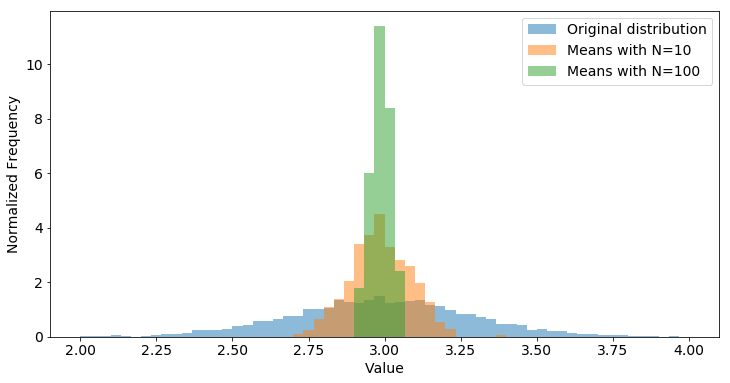

In [23]:
kwargs = dict(density=True, bins=60, alpha=.5, range=(2,4))

# See the docs on matplotlib.pyplot.hist()
#    density=True normalizes the distribution
#    range sets the x-axis range
#    alpha=0.5 makes the histogram bins partially transparent.

plt.hist(a, **kwargs, label='Original distribution')
plt.hist(find_means(a,N=10), **kwargs, label='Means with N=10')
plt.hist(find_means(a,N=100), **kwargs, label='Means with N=100')
plt.xlabel('Value')
plt.ylabel('Normalized Frequency')
plt.legend();

Compute the standard deviations of the above.

In [24]:
print('Std. Dev. of original dist: {:.3f}'.format(a.std()))
print('Std. Dev. of N={:d} means: {:.3f}'.format(10,find_means(a,N=10).std()))
print('Std. Dev. of N={:d} means: {:.3f}'.format(100,find_means(a,N=100).std()))

Std. Dev. of original dist: 0.301
Std. Dev. of N=10 means: 0.099
Std. Dev. of N=100 means: 0.032


### What does uncertainty propagation say?

Taking a mean is an operation on a data set from a distribution.  The question is: what is the distribution of mean values created from that data set?

Formula for means:

$$\langle x\rangle_n = \frac{1}{n}\left(x_1 + x_2+ \ldots + x_n\right)$$

From the sum/difference rule

$$\sigma^2_{x_1 + x_2 + \ldots + x_n} = \sigma^2_1 + \sigma^2_2+ \ldots + \sigma^2_n$$

And because the $\sigma$'s are all the same (coming from the same distribution)

$$\sigma_{x_1 + x_2 + \ldots + x_n} = \sqrt{n\sigma^2} = \sigma\sqrt{n}$$

Finally by the constant rule, we divide by $n$ to get

$$\sigma_{\langle x\rangle_n} = \frac{\sigma}{\sqrt{n}}$$

This is called the **standard deviation of the mean** or **"standard error."**  It quantifies the fact that combining data produces a smaller statistical uncertainty.

If you want to improve your precision without doing any other thing, take more measurements!  But remember: the precision goes as a square root: to improve the precision by a factor of 2, you need 4 times as many measurements!

## What about non-normal distributions?

So far, I have used Gaussian or normal distributions in these examples.  What if our data sets come from other kinds of distributions?  How does that affect the uncertainties?

Find out:

* An **exponential distribution** follows $$P_{\rm exp}(x;\beta) = \frac{1}{\beta}e^{-x/\beta}$$ for $x>0$ and zero elsewhere.


* A **uniform distribution** follows $$P_{\rm uni}(x;a,b) = \frac{1}{b-a}$$ for $a\le x\lt b$ and zero elsewhere.

Let's look at these:

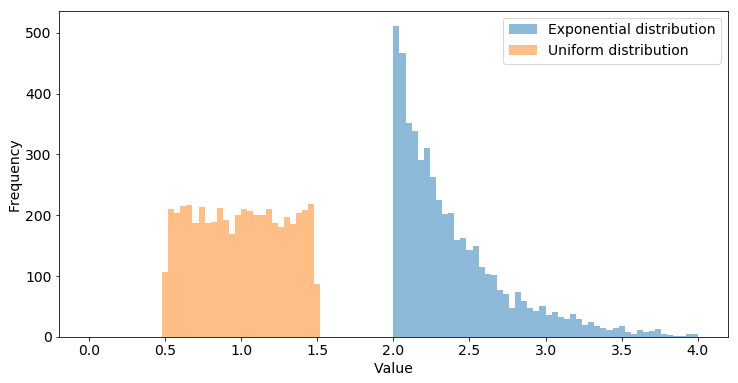

In [25]:
exponential_data = 2.0 + np.random.exponential(scale=0.4,size=5000)
uniform_data = np.random.uniform(low=0.5, high=1.5, size=5000)

kwargs = dict(bins=100, alpha=.5, range=(0,4))

plt.hist(exponential_data,**kwargs,label='Exponential distribution')
plt.hist(uniform_data,**kwargs,label='Uniform distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend();

Properties?  Look at mean and standard deviation

In [26]:
print('For exponential distribution:')
print('  Mean = {:.4f}'.format(exponential_data.mean()))
print('  Std. Dev = {:.4f}'.format(exponential_data.std()))

print('\nFor uniform distribution:')
print('  Mean = {:.4f}'.format(uniform_data.mean()))
print('  Std. Dev = {:.4f}'.format(uniform_data.std()))


For exponential distribution:
  Mean = 2.3999
  Std. Dev = 0.4027

For uniform distribution:
  Mean = 0.9964
  Std. Dev = 0.2911


Take data from these and find averages.  Look at the distribution of averages of, say, 10:

From exponential distribution with N=10:
  Mean = 2.3999
  Std. Dev = 0.1270

From uniform distribution with N=10:
  Mean = 0.9964
  Std. Dev = 0.0927


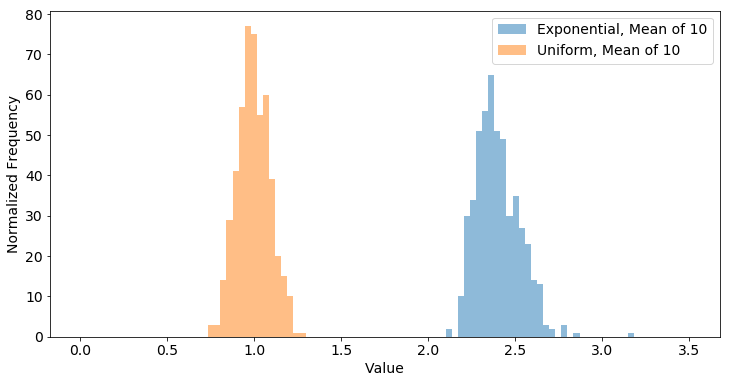

In [27]:
N=10
exp_means = find_means(exponential_data,N=N)
uni_means = find_means(uniform_data,N=N)

print('From exponential distribution with N={:d}:'.format(N))
print('  Mean = {:.4f}'.format(exp_means.mean()))
print('  Std. Dev = {:.4f}'.format(exp_means.std()))

print('\nFrom uniform distribution with N={:d}:'.format(N))
print('  Mean = {:.4f}'.format(uni_means.mean()))
print('  Std. Dev = {:.4f}'.format(uni_means.std()))


kwargs = dict(bins=100, alpha=.5, range=(0,3.5))

plt.hist(exp_means, **kwargs, label="Exponential, Mean of {:d}".format(N))
plt.hist(uni_means, **kwargs, label="Uniform, Mean of {:d}".format(N))
plt.xlabel('Value')
plt.ylabel('Normalized Frequency')
plt.legend();

# Wait. Wuut? *How did the shape change?*

### The CENTRAL LIMIT THEOREM.  

#### The central limit theorem says: "The average of $N$ random draws from a parent distribution of arbitrary shape converges to a **normal distribution** as $N$ gets large."

AND

#### "The mean and standard deviation converge to predictable values."

## Test uncertainty propagation here

What would we get from the rules for uncertainty propoagation?  Is it still true that $\sigma_n = \sigma/\sqrt{n}$?

In [28]:
print('From exponential distribution, taking means of {:d}:'.format(N))
print(' Calculated Std. Dev. = {:.3f}'.format(exp_means.std()))
print('   Expected Std. Dev. = {:.3f}'.format(exponential_data.std()/np.sqrt(N)))

print('\nFrom uniform distribution, taking means of {:d}:'.format(N))
print(' Calculated Std. Dev. = {:.3f}'.format(uni_means.std()))
print('   Expected Std. Dev. = {:.3f}'.format(uniform_data.std()/np.sqrt(N)))

From exponential distribution, taking means of 10:
 Calculated Std. Dev. = 0.127
   Expected Std. Dev. = 0.127

From uniform distribution, taking means of 10:
 Calculated Std. Dev. = 0.093
   Expected Std. Dev. = 0.092


### Combining non-normal distributions

Take their sum and difference.  Compare results to standard error propagation.

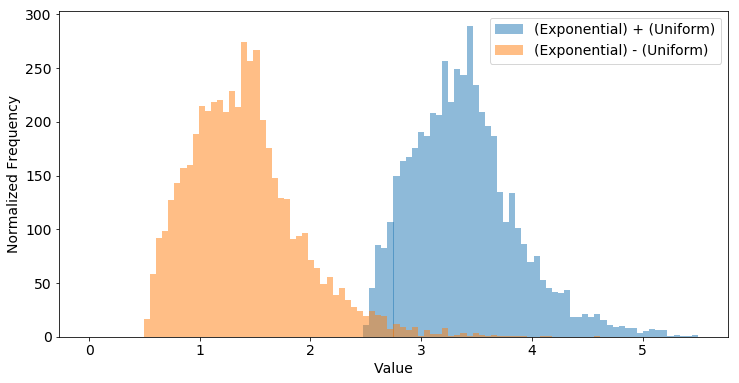

In [29]:
sum_data = uniform_data + exponential_data
diff_data = exponential_data - uniform_data

kwargs = dict(bins=100, alpha=.5, range=(0,5.5))

plt.hist(sum_data, **kwargs, label="(Exponential) + (Uniform)")
plt.hist(diff_data, **kwargs, label="(Exponential) - (Uniform)")
plt.xlabel('Value')
plt.ylabel('Normalized Frequency')
plt.legend();

### Interesting . . .

. . .It looks like a convolution of the two distributions.  Check the statistics against standard error propagation.

In [30]:
usum_data = unc.ufloat(sum_data.mean(),sum_data.std())
udiff_data = unc.ufloat(diff_data.mean(),diff_data.std())

uexp_data = unc.ufloat(exponential_data.mean(),exponential_data.std())
uunif_data = unc.ufloat(uniform_data.mean(), uniform_data.std())

print('Exponential data: {:.3uP}'.format(uexp_data))
print('Uniform data: {:.3uP}'.format(uunif_data))

print('\nSum: {:.3uP}'.format(usum_data))
print('Expected sum: {:.3uP}'.format(uexp_data+uunif_data))

print('\nDifference: {:.3uP}'.format(udiff_data))
print('Expected difference: {:.3uP}'.format(uexp_data-uunif_data))


Exponential data: 2.400±0.403
Uniform data: 0.996±0.291

Sum: 3.396±0.492
Expected sum: 3.396±0.497

Difference: 1.403±0.502
Expected difference: 1.403±0.497
